#  Electrolysis of Pharmaceuticals
Meheryar Kasad and Scott Calabrese Barton

Adapted from:
1. Y. Lan, C. Coetsier, C. Causserand and K. Groenen Serrano, "An experimental and modelling study of the electrochemical oxidation of pharmaceuticals using a boron-doped diamond anode", Chem. Eng. J., 333, 486–494 (2018). [doi:10.1016/j.cej.2017.09.164](http://doi.org/10.1016/j.cej.2017.09.164).

In [1]:
%pylab inline
from scipy.integrate import solve_bvp, solve_ivp
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
kr=5.5E6  # m^3/(mol s)
kf=1.3E5  # m^3/(mol s)
km=6E6    # m^3/(mol s)

Dr= 2.20E-09 #m^s/s
Df= 1.70E-09 #m^2/s
Dm= 4.96E-10 #m^2/s

CfB0=0.1 #mol/m^3, initial bulk formic acid concentration
CmB0=0.1 #mol/m^3, initial bulk maleic acid concentration

CfL, CmL=CfB0, CmB0 # set boundary concentrations to initial bulk values

delta=5E-6  # m
L=25E-6  # m
icd= 0.1 # A/m2

F=96485 # J/C
zr= 1

In [3]:
def deq(x, y):

    Cr, Cf, Cm, vr, vf, vm = y
    
    dCrdx, dCfdx, dCmdx= vr, vf, vm
    
    dvrdx= (kr*Cr**2 + kf*Cr*Cf + km*Cr*Cm) / Dr
    
    dvfdx=  kf*Cr*Cf / Df
    
    dvmdx=  kf*Cr*Cm / Dm

    return stack([dCrdx, dCfdx, dCmdx, dvrdx, dvfdx, dvmdx])

In [4]:
def bc(u0, ud):

    Cr0, Cf0, Cm0, vr0, vf0, vm0 = u0
    Crd, Cfd, Cmd, vrd, vfd, vmd = ud

    res1 = Crd
    res2 = vr0 + icd/zr/F/Dr

    res3 = vf0
    res4 = vfd - (CfL - Cfd)/(L-delta)

    res5 = vm0
    res6 = vmd - (CmL - Cmd)/(L-delta)

    return array([res1, res2, res3, res4, res5, res6])

In [5]:
# Initial guess
x=linspace(0,delta)
uinit=array([0,CfL,CmL,0,0,0]) [:,None]   # a column vector
yinit=uinit * zeros([len(uinit),len(x)])

In [6]:
deq(x,yinit)
bc(yinit[:,0],yinit[:,-1])

array([    0.        ,   471.10478784,     0.        , -5000.        ,
           0.        , -5000.        ])

In [7]:
icd=50
sol=solve_bvp(deq,bc,x,yinit,tol=0.02,max_nodes=10**6,verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.28e+01       2.71e-08          50             63       
       2          8.45e-01       1.82e-12          113            48       
       3          7.12e-03       4.55e-13          161             0       
Solved in 3 iterations, number of nodes 161. 
Maximum relative residual: 7.12e-03 
Maximum boundary residual: 4.55e-13


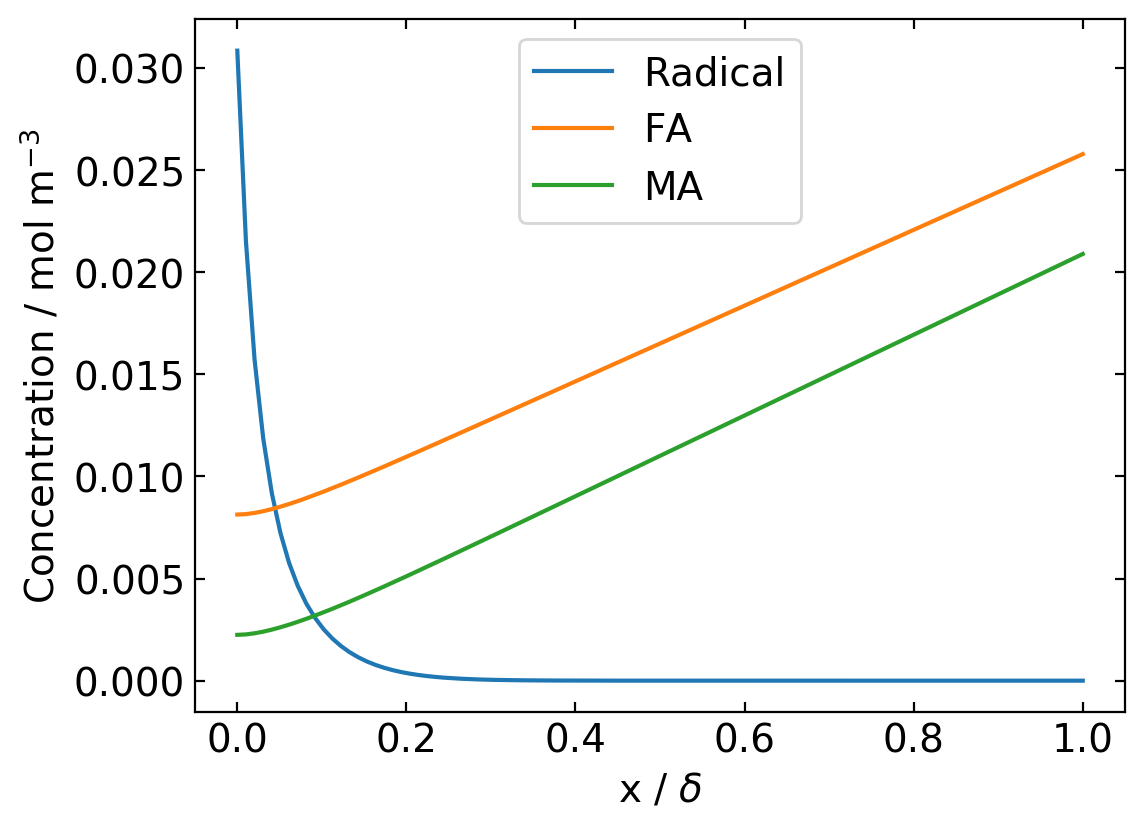

In [8]:
plot(sol.x/delta,sol.y[[0,1,2]].T)

xlabel('x / $\delta$')
ylabel('Concentration / mol m$^{-3}$')
legend(['Radical', 'FA', 'MA'])
show()

## Rate function

In [9]:
def rate(icd=50, C=array([CfB0, CmB0])):
    
    CfL, CmL= C
    
    def deq(x, y):

        Cr, Cf, Cm, vr, vf, vm = y

        dCrdx, dCfdx, dCmdx= vr, vf, vm

        dvrdx= (kr*Cr**2 + kf*Cr*Cf + km*Cr*Cm) / Dr

        dvfdx=  kf*Cr*Cf / Df

        dvmdx=  kf*Cr*Cm / Dm

        return stack([dCrdx, dCfdx, dCmdx, dvrdx, dvfdx, dvmdx])

    def bc(u0, ud):

        Cr0, Cf0, Cm0, vr0, vf0, vm0 = u0
        Crd, Cfd, Cmd, vrd, vfd, vmd = ud

        res1 = Crd
        res2 = vr0 + icd/zr/F/Dr

        res3 = vf0
        res4 = vfd - (CfL - Cfd)/(L-delta)

        res5 = vm0
        res6 = vmd - (CmL - Cmd)/(L-delta)

        return array([res1, res2, res3, res4, res5, res6])
    
    # Initial guess
    x=linspace(0,delta)
    uinit=array([0,CfL,CmL,0,0,0]) [:,None]   # a column vector
    yinit=uinit * zeros([len(uinit),len(x)])
    
    #solution
    sol=solve_bvp(deq,bc,x,yinit,tol=0.02,max_nodes=10**6,verbose=0)
    
    #flux of reactants
    Nf=-Df*sol.y[4,-1]
    Nm=-Dm*sol.y[5,-1]
    
    return Nf, Nm, sol

In [10]:
Nf, Nm, sol= rate()
Nf, Nm

(-6.307951682545201e-06, -1.9617304498921917e-06)

## Batch Reactor

In [11]:
A= 1000 # m2/m3, electrode area per unit reactor volume

In [12]:
def BRfun(t, u):

    CfL, CmL = u

    Nf, Nm, sol = rate(icd=icd, C=[CfL, CmL])

    dCfdt = A*Nf*(CfL > 0)  # set the rate to zero if concentration is negative
    dCmdt = A*Nm*(CmL > 0)

    return array([dCfdt, dCmdt])  # mol/m3/s


BRfun(0, array([CfB0, CmB0])/4)

array([-0.00161576, -0.00049825])

In [13]:
tmax=10*60  # s

sol=solve_ivp(BRfun,(0,tmax),[CfB0, CmB0])

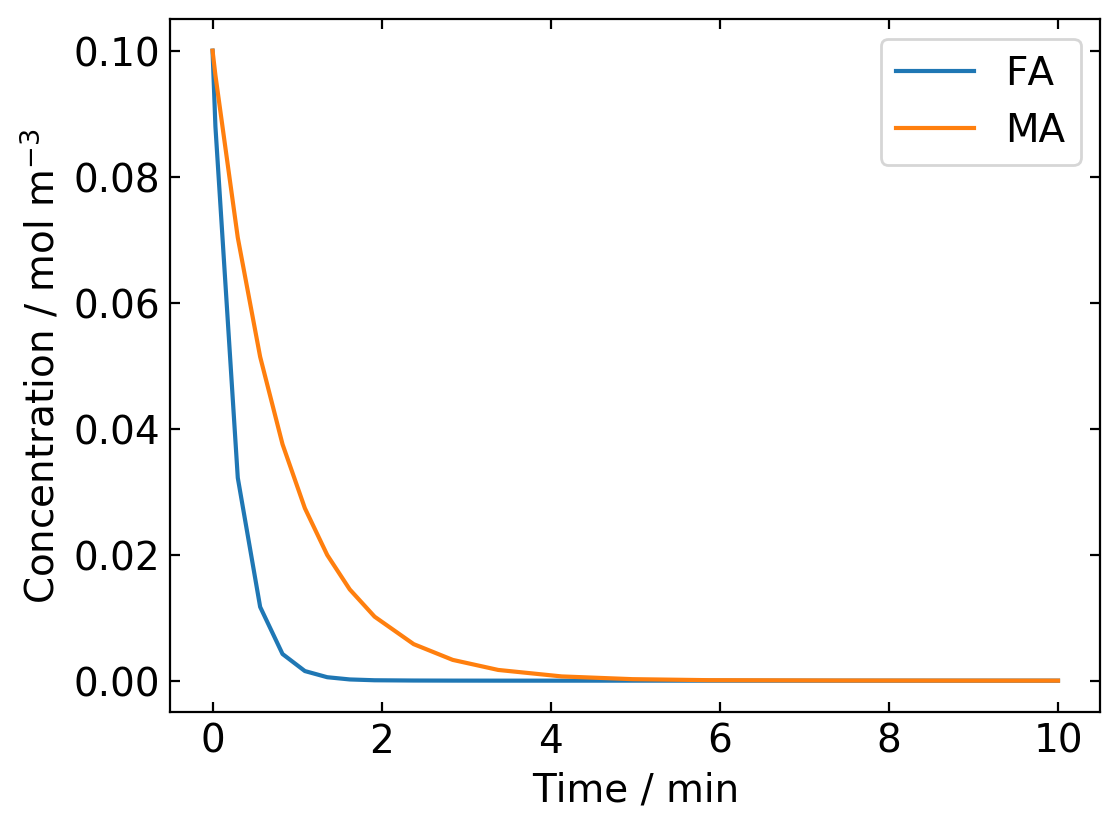

In [14]:
plot(sol.t/60, sol.y.T)

xlabel('Time / min')
ylabel('Concentration / mol m$^{-3}$')
legend(['FA', 'MA'])
show()